In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import os
from ctd.comparison.analysis.tt.tasks.tt_MultiTask import Analysis_TT_MultiTask 
# Import pca
from sklearn.decomposition import PCA
import glob
import cv2
import shutil
import imageio

In [2]:

suffix = "MultiTaskNoisyGRU"
filepath1 = (
"/home/csverst/Github/CtDBenchmark/content/trained_models/task-trained/tt_MultiTask/"
)

phase_plot = "stim1"
phase_for_pca = "stim1"
task_to_analyze = "MemoryPro"
task_for_pca = "MemoryPro"
plot_fps = True
comp = Analysis_TT_MultiTask(run_name=suffix, filepath=filepath1)
    
# Get the model outputs
ics, inputs, targets = comp.get_model_inputs_noiseless()
out_dict = comp.get_model_outputs_noiseless()
lats = out_dict["latents"]
outputs = out_dict["controlled"]

# Get the flag for the task (which trials are the correct task)
pca_flag, pca_phase_task = comp.get_task_flag(task_for_pca)
lats4pca = lats[pca_flag].detach().numpy()

# Get the latent activity for the phase we want to do PCA on
lats_phase_pca = comp.get_data_from_phase(pca_phase_task, phase_for_pca, lats4pca)
lats_phase_pca_flat = np.concatenate(lats_phase_pca) 

# Compute PCA on the latents in the phase
pca = PCA(n_components=3)
pca.fit(lats_phase_pca_flat)

plot_flag, phase_task = comp.get_task_flag(task_to_analyze)

phase_names = phase_task[0].keys()
phase_names_pca = pca_phase_task[0].keys()
num_phases_pca = len(phase_names_pca)
num_phases = len(phase_names)

# Get the latents and outputs for the task

lats4plot = lats[plot_flag].detach().numpy()
outputs4plot = outputs[plot_flag].detach().numpy()
targets4plot = targets[plot_flag].detach().numpy()
trial_lens = [phase['response'][1] for phase in phase_task]
targ_list = np.array([targets4plot[i, trial_lens[i]-1,1:] for i in range(len(trial_lens))])
targ_ang_list = np.arctan2(targ_list[:,1], targ_list[:,0])
B, T, D = lats4plot.shape
# Get the readout matrix
readout = comp.wrapper.model.readout

lats_pca = pca.transform(lats4plot.reshape(-1, D))
lats_pca = lats_pca.reshape(B, T, -1)

# Get the full trial latents in the phase PCA space

Computing fixed points for interp. 0 of 20

Iteration 500/2000
q = 1.71E-04 +/- 4.82E-04
dq = 1.05E-06 +/- 3.22E-06

Iteration 1000/2000
q = 6.98E-05 +/- 1.74E-04
dq = 1.53E-06 +/- 5.56E-06

Iteration 1500/2000
q = 4.17E-05 +/- 9.41E-05
dq = 1.54E-06 +/- 4.20E-06

Iteration 2000/2000
q = 2.98E-05 +/- 5.91E-05
dq = 1.64E-06 +/- 4.68E-06
Maximum iteration count reached. Terminating.
Found 1024 unique fixed points.
Computing fixed points for interp. 1 of 20

Iteration 500/1000
q = 1.99E-05 +/- 2.40E-05
dq = 1.44E-06 +/- 4.85E-06

Iteration 1000/1000
q = 1.65E-05 +/- 1.73E-05
dq = 1.84E-06 +/- 5.24E-06
Maximum iteration count reached. Terminating.
Found 1024 unique fixed points.
Computing fixed points for interp. 2 of 20

Iteration 500/1000
q = 1.68E-05 +/- 1.66E-05
dq = 1.94E-06 +/- 7.38E-06

Iteration 1000/1000
q = 1.49E-05 +/- 1.36E-05
dq = 2.36E-06 +/- 6.43E-06
Maximum iteration count reached. Terminating.
Found 1024 unique fixed points.
Computing fixed points for interp. 3 of 20

Iter

/home/csverst/Github/CtDBenchmark/ctd/comparison/analysis/tt/tasks/tt_MultiTask.py:220: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


20


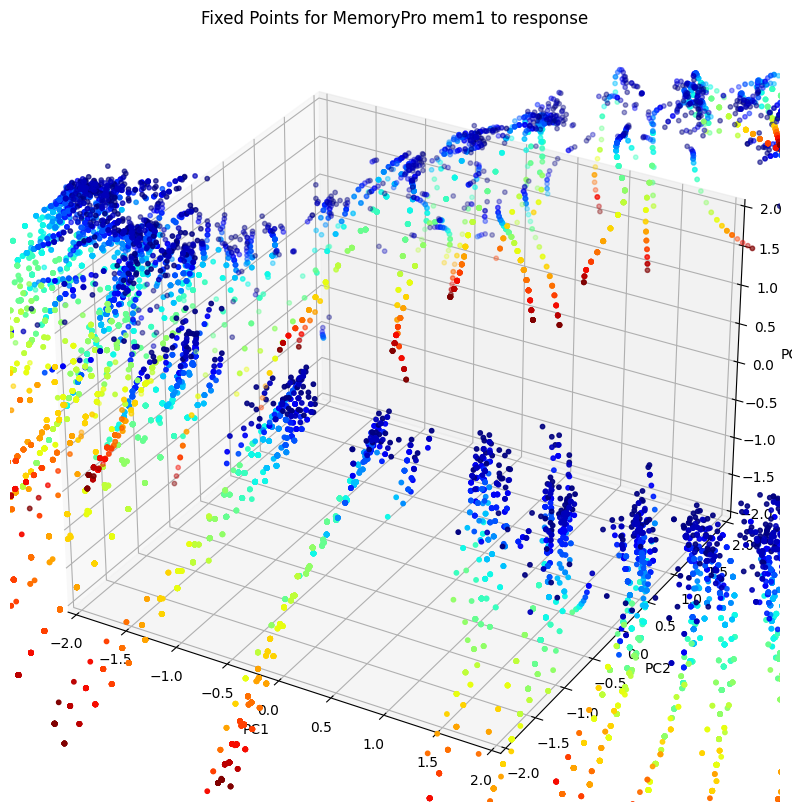

In [4]:
n_interp_steps = 20
fps = comp.plot_fps_phase_interpolation(
    task= task_to_analyze, 
    phase1= 'mem1', phase2= 'response', 
    n_interp_steps=n_interp_steps, max_iters_init = 2000, max_iters = 1000,
    lr = 5e-3, use_noisy= False)
xstars = np.array([fp.xstar for fp in fps])

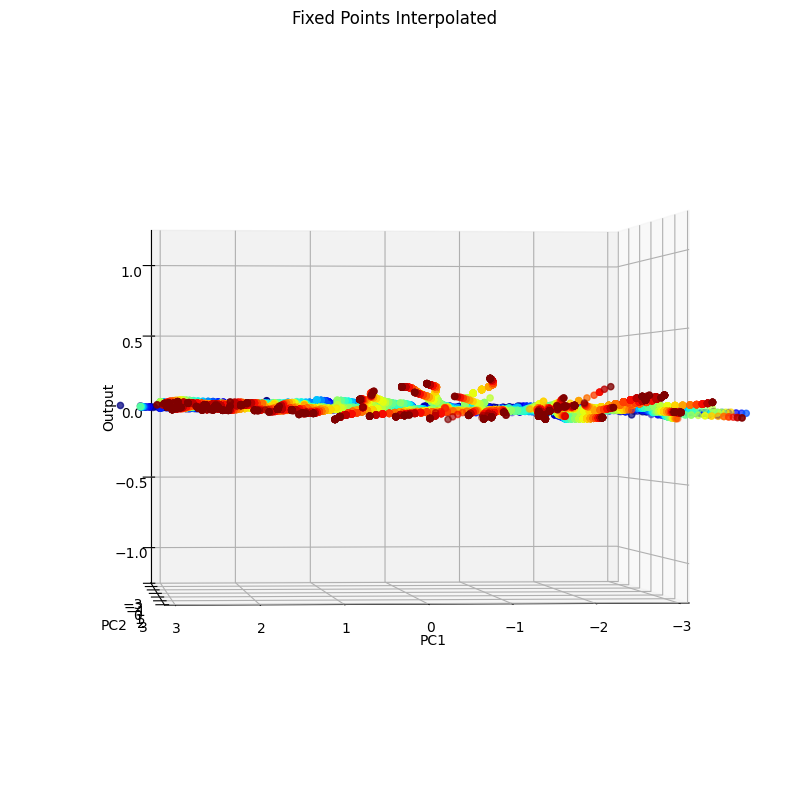

In [5]:
q_thresh = 1e-5
q_flag = np.array([fp.qstar < q_thresh for fp in fps])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(np.linspace(0,1,n_interp_steps))
for i in range(n_interp_steps):
    xstar = xstars[i,:,:]
    xstar_pca = pca.transform(xstar)
    xstar_readout = readout(torch.Tensor(xstar)).detach().numpy()
    ax.scatter(
        xstar_pca[:,0], 
        xstar_pca[:,1], 
        xstar_readout[:,1], 
        color = colors[i], 
        label = f"Interp {i}"
        )
    
    # puase for 1 second
    # plt.pause(1)
# set view to see the plot from above
ax.view_init(90, 0)
# set view to see the plot from the front
ax.view_init(0, 85)
# ax.legend()

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Output')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-1.2, 1.2])
ax.set_title('Fixed Points Interpolated') 
# plt.savefig(plot_path + "FixedPointsPhaseInterp.pdf")
plt.show()

In [6]:
fps_task = comp.compute_fps_task_interpolation(
    task1 = "MemoryPro",
    task2 = "MemoryAnti",
    phase = 'mem1',
    n_interp_steps=n_interp_steps, 
    max_iters_init = 10000, max_iters = 2000,
    lr = 1e-3, use_noisy= False)
    
xstars_task = np.array([fp.xstar for fp in fps_task])

Computing fixed points for interp. 0 of 20

Iteration 500/10000
q = 2.51E-01 +/- 6.20E-02
dq = 1.06E-03 +/- 3.24E-04

Iteration 1000/10000
q = 3.69E-02 +/- 1.13E-02
dq = 1.24E-04 +/- 2.88E-05

Iteration 1500/10000
q = 1.00E-02 +/- 4.76E-03
dq = 1.82E-05 +/- 7.10E-06

Iteration 2000/10000
q = 5.22E-03 +/- 2.63E-03
dq = 5.12E-06 +/- 2.73E-06

Iteration 2500/10000
q = 3.40E-03 +/- 1.67E-03
dq = 2.62E-06 +/- 1.42E-06

Iteration 3000/10000
q = 2.38E-03 +/- 1.13E-03
dq = 1.61E-06 +/- 8.48E-07

Iteration 3500/10000
q = 1.72E-03 +/- 8.05E-04
dq = 1.06E-06 +/- 5.44E-07

Iteration 4000/10000
q = 1.28E-03 +/- 5.89E-04
dq = 7.39E-07 +/- 3.68E-07

Iteration 4500/10000
q = 9.66E-04 +/- 4.39E-04
dq = 5.32E-07 +/- 2.59E-07

Iteration 5000/10000
q = 7.37E-04 +/- 3.33E-04
dq = 3.93E-07 +/- 1.89E-07

Iteration 5500/10000
q = 5.67E-04 +/- 2.54E-04
dq = 2.95E-07 +/- 1.40E-07

Iteration 6000/10000
q = 4.38E-04 +/- 1.95E-04
dq = 2.24E-07 +/- 1.06E-07

Iteration 6500/10000
q = 3.40E-04 +/- 1.50E-04
dq = 1.71E

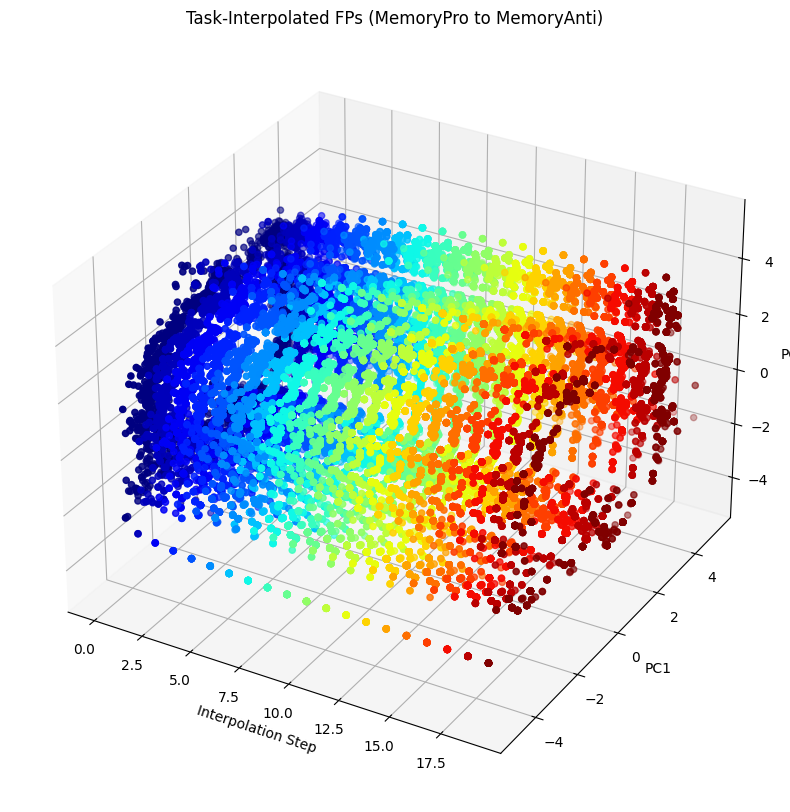

In [7]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.jet(np.linspace(0,1,n_interp_steps))
for i in range(n_interp_steps):
    xstar = xstars_task[i,:,:]
    xstar_pca = pca.transform(xstar)
    xstar_readout = readout(torch.Tensor(xstar)).detach().numpy()
    ax.scatter(
        i, 
        xstar_pca[:,0], 
        xstar_pca[:,1], 
        color = colors[i]
        )

ax.set_xlabel('Interpolation Step')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

# set view to see the plot from the front
# ax.view_init(0, 90)
ax.set_title('Task-Interpolated FPs (MemoryPro to MemoryAnti)') 

# plt.savefig(plot_path + "FixedPointsTaskInterp.png")
# plt.savefig(plot_path + "FixedPointsTaskInterp.pdf")
plt.show()

Computing fixed points for context using ['context', 'mem1']

Iteration 500/20000
q = 3.40E-04 +/- 9.44E-04
dq = 1.59E-06 +/- 4.43E-06

Iteration 1000/20000
q = 1.33E-04 +/- 3.39E-04
dq = 1.83E-06 +/- 6.59E-06

Iteration 1500/20000
q = 7.44E-05 +/- 1.71E-04
dq = 1.74E-06 +/- 5.86E-06

Iteration 2000/20000
q = 4.90E-05 +/- 9.99E-05
dq = 1.77E-06 +/- 6.15E-06

Iteration 2500/20000
q = 3.56E-05 +/- 6.38E-05
dq = 1.67E-06 +/- 5.03E-06

Iteration 3000/20000
q = 2.80E-05 +/- 4.37E-05
dq = 1.88E-06 +/- 5.58E-06

Iteration 3500/20000
q = 2.29E-05 +/- 3.29E-05
dq = 1.59E-06 +/- 5.02E-06

Iteration 4000/20000
q = 1.91E-05 +/- 2.59E-05
dq = 1.55E-06 +/- 4.29E-06

Iteration 4500/20000
q = 1.64E-05 +/- 2.06E-05
dq = 1.51E-06 +/- 4.58E-06

Iteration 5000/20000
q = 1.42E-05 +/- 1.62E-05
dq = 1.50E-06 +/- 4.45E-06

Iteration 5500/20000
q = 1.47E-05 +/- 2.18E-05
dq = 1.77E-06 +/- 4.84E-06

Iteration 6000/20000
q = 1.27E-05 +/- 1.66E-05
dq = 1.73E-06 +/- 5.20E-06

Iteration 6500/20000
q = 1.16E-05 +/- 1

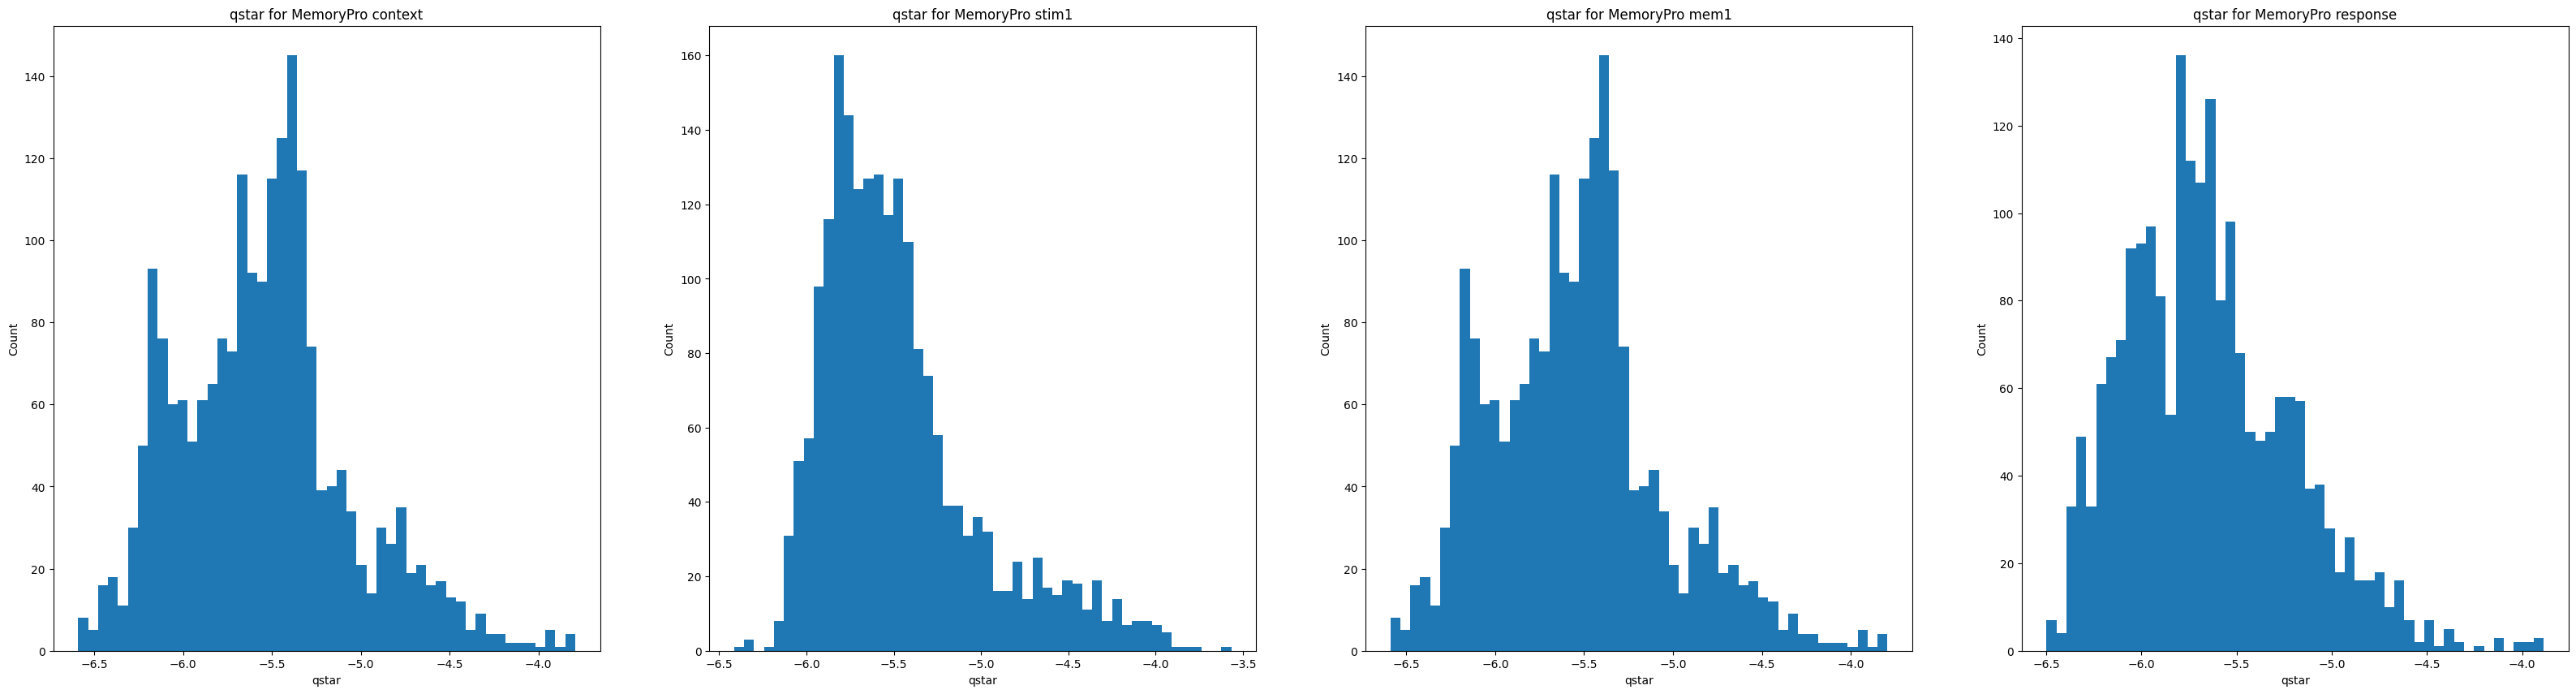

In [8]:
fps = {}
xstar_pca = []
fps_out = []
q_star = []
phase_names = ['context', 'stim1', 'mem1', 'response']
phase_list = [['context', 'mem1'], 'stim1', ['context', 'mem1'], 'response']
# For each phase, compute the fixed points
for i, phase_for_fp in enumerate(phase_list):
    print(f"Computing fixed points for {phase_names[i]} using {phase_for_fp}")
    # Returns fps and x_trajs in the original space
    fps[phase_names[i]]= comp.compute_fps_phase(
        phases=phase_for_fp, 
        task_to_analyze=task_to_analyze, 
        noise_scale=0.0, lr = 5e-3, 
        max_iters = 20000, use_noisy = False
        )

    # Transform the fps and x_trajs into the PCA space
    xstar= fps[phase_names[i]].xstar
    xstar_pca.append(pca.transform(xstar))
    fps_out.append(readout(torch.Tensor(xstar)).detach().numpy())
    q_star.append(fps[phase_names[i]].qstar)
xstar_pca = np.stack(xstar_pca, axis = 0)
fps_out = np.stack(fps_out, axis = 0)
fps_mat = np.concatenate((xstar_pca[:,:,:2], fps_out[:,:,1:2]), axis=2)
q_star = np.stack(q_star, axis = 0)
# Set values of qstar that are zero to 1e-16 for plotting
q_star[q_star == 0] = 1e-16
fig = plt.figure(figsize=(10*num_phases, 10))
for i, phase in enumerate(phase_names):
    # Add histogram of qstar
    ax = fig.add_subplot(1, num_phases, i+1)
    ax.hist(np.log10(q_star[i]), bins=50)
    ax.set_xlabel("qstar")
    ax.set_ylabel("Count")
    ax.set_title(f"qstar for {task_to_analyze} {phase}")
# plt.savefig(comp.plot_path + f"qstar_{task_to_analyze}_{phase}.png", dpi=300)
plt.show()


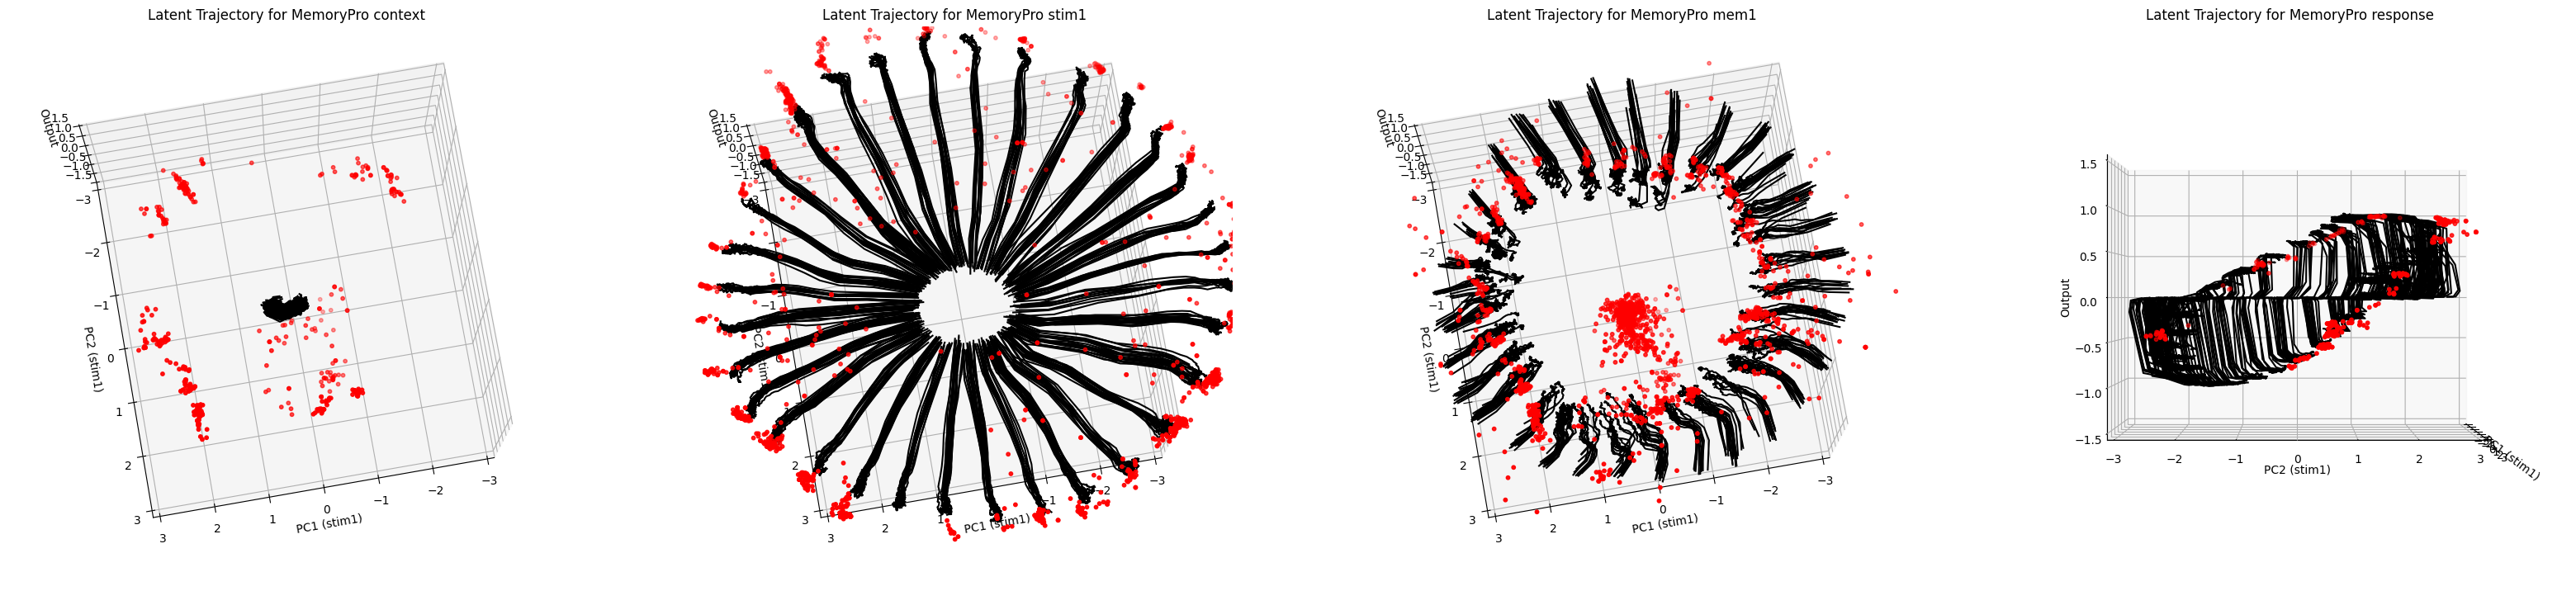

In [9]:
# window to only FPs whose q values are less than thresh
fps_plot = fps_mat.copy()
threshs = [1e-6, 1e-5, 1e-5, 1e-6]
for i, phase in enumerate(phase_names):
    q_flag = q_star[i] < threshs[i]
    fps_plot[i, ~q_flag, :] = np.nan
# combine lats_pca 1 and 2 and output 1
plot_mat = np.concatenate((lats_pca[:, :, :2], outputs4plot[:, :, 1:2]), axis=2)
fig = plt.figure(figsize=(10*num_phases, 10))
for i, phase in enumerate(phase_names):
    ax = fig.add_subplot(1, num_phases, i+1, projection="3d")
    for j, phase_dict in enumerate(phase_task):
        start_idx = phase_dict[phase][0]
        end_idx = phase_dict[phase][1]
        ax.plot(
            plot_mat[j,start_idx:end_idx, 0], 
            plot_mat[j,start_idx:end_idx, 1], 
            plot_mat[j,start_idx:end_idx, 2], 
            c="k"
            )
    ax.scatter(
        fps_plot[i,:,0], 
        fps_plot[i,:,1], 
        fps_plot[i,:,2], 
        s=10, c="r"
        )
    ax.set_xlabel(f"PC1 ({phase_for_pca})")
    ax.set_ylabel(f"PC2 ({phase_for_pca})")
    ax.set_zlabel("Output")
    ax.set_title(f"Latent Trajectory for {task_to_analyze} {phase}")
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-1.5, 1.5])
    
    ax.view_init(80, 80)
    if phase == 'response':
        ax.view_init(0, 0)
plt.show()
# plt.savefig(comp.plot_path + f"LatentTraj_{task_to_analyze}_{phase}.png", dpi=300)

In [ ]:

def angles_to_colors(angles):
    # Normalize the angles to the range [0, 1]
    normalized = (angles + np.pi) / (2 * np.pi)
    
    # Use a circular (hsv) colormap
    colormap = plt.cm.hsv
    
    # Map normalized angles to colors
    colors = colormap(normalized)
    return colors

def create_frames(
        plot_mat,
        fps_mat, 
        q_star, 
        threshs,
        trail_length = 5, 
        target_ang_list = None, 
        num_frames_per_phase=60
        ):
    frame_folder = "combined_frames"
    os.makedirs(frame_folder, exist_ok=True)
    frame_count = 0
    
    # Make a colormap for the phases
    if target_ang_list is None:
        colors = plt.cm.get_cmap('gist_rainbow', len(phase_names))
    else:
        colors = angles_to_colors(target_ang_list)

    colors_label = plt.cm.get_cmap('gist_rainbow', len(phase_names))
    
    # Make a colormap for the phases
    for i, phase in enumerate(phase_names):
        print(f"\rCreating frames for {phase}", end="")
        for frame in range(num_frames_per_phase):
            print(f"Frame {frame_count+1} of {num_frames_per_phase * len(phase_names)}")
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection="3d")

            # Plotting logic (adapted for trail effect)
            # Plot the trajectory up to the current frame
            q_flag = q_star[i] < threshs[i]
            fps_phase = fps_mat[i, q_flag, :]
            ax.scatter(fps_phase[:, 0], 
                       fps_phase[:, 1], 
                       fps_phase[:, 2], 
                       s=10, c="k")

            for j, phase_dict in enumerate(phase_task):
                start_idx = phase_dict[phase][0]
                end_idx = min(
                    phase_dict[phase][1], 
                    start_idx + int((phase_dict[phase][1] - start_idx) * frame / num_frames_per_phase)
                    )
                idx1 = max(0, end_idx - trail_length)

                if target_ang_list is None:
                    ax.plot(plot_mat[j, idx1:end_idx, 0], 
                            plot_mat[j, idx1:end_idx, 1], 
                            plot_mat[j, idx1:end_idx, 2], 
                            c=colors(i))
                else:
                    ax.plot(plot_mat[j, idx1:end_idx, 0], 
                            plot_mat[j, idx1:end_idx, 1], 
                            plot_mat[j, idx1:end_idx, 2], 
                            c=colors[j])
            
            # Set labels, limits, and title
            ax.set_xlabel(f"PC1 ({phase_for_pca})")
            ax.set_ylabel(f"PC2 ({phase_for_pca})")
            ax.set_zlabel("Output")
            ax.set_title(f"{task_to_analyze}")
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            ax.set_zlim([-1.5, 1.5])
            # Add a text-box with the phasename and color-coded

            for label_num, phase_name_plot in enumerate(phase_names):
                
                props = dict(
                    boxstyle='round', 
                    facecolor=colors_label(label_num), 
                    alpha=0.25
                    )
                props_bold = dict(
                    boxstyle='round', 
                    facecolor=colors_label(label_num), 
                    alpha=1.0
                    )
                if phase_name_plot == phase:
                    ax.text2D(
                        0.05, 0.95-0.05*label_num, phase_name_plot, 
                        transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props_bold, 
                        fontweight='bold'
                        )
                else:
                    ax.text2D(
                        0.05, 0.95-0.05*label_num, 
                        phase_name_plot, transform=ax.transAxes, 
                        fontsize=14,
                        verticalalignment='top', bbox=props
                        )


            # Change view angle for each frame
            ax.view_init(
                30,
                30 + (frame / num_frames_per_phase) * 60
                )

            plt.savefig(f"{frame_folder}/frame_{frame_count:04d}.png")
            plt.close(fig)
            frame_count += 1


def create_combined_video(fps=10):
    frame_folder = "combined_frames"
    img_array = []
    for filename in sorted(glob.glob(f'{frame_folder}/*.png')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    video = cv2.VideoWriter(
        comp.plot_path +f'{task_to_analyze}_{task_for_pca}PCs_combined_video.avi',
         cv2.VideoWriter_fourcc(*'DIVX'), 
         fps, size)

    for img in img_array:
        video.write(img)

    video.release()

    # Delete all frame files
    for filename in glob.glob(f'{frame_folder}/*.png'):
        os.remove(filename)

    # Delete the frame folder
    shutil.rmtree(frame_folder)


def create_combined_gif(fps=20):
    frame_folder = "combined_frames"
    filenames = sorted(glob.glob(f'{frame_folder}/*.png'))

    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))

    # Set the duration for each frame
    duration = 1 / fps

    # Save the frames as a gif
    imageio.mimsave(f'{task_to_analyze}_{task_for_pca}PCs_combined_video.gif', images, duration=duration)

    # Cleanup: Delete frames and folder
    for filename in filenames:
        os.remove(filename)
    os.rmdir(frame_folder)

  
create_frames(
    plot_mat,fps_mat, 
    q_star, 
    threshs,
    target_ang_list=targ_ang_list, 
    num_frames_per_phase=60
    )
create_combined_gif()

# create_combined_video()